In [1]:
import numpy as np
import scipy as sp
import sys

sys.version


'3.3.5 |Anaconda 2.2.0 (64-bit)| (default, Sep  2 2014, 13:55:40) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

data log-likelihood for parameter initializations:
-20373.4730878
data log-likelihood for fitted parameters:
-19027.9705494
elapsed time for fitting is
74.45420098304749


/home/mackelab/anaconda/envs/py3k/lib/python3.3/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


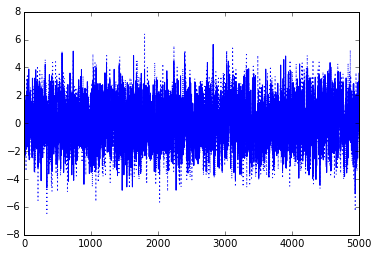

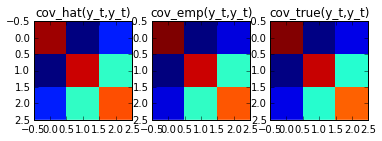

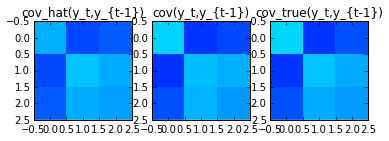

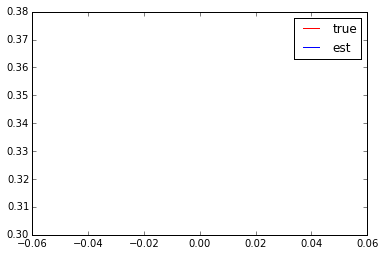

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting

from IPython import display  # for live plotting

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

from scipy.io import savemat # store results for comparison with Matlab code

xDim = 1
yDim = 3

T = 5000
observationScheme = {'subpops': [list(range(2)), list(range(1,yDim))],
             'obsTime': [round(T/4), T],
             'obsPops': [0, 1]}

while True:
    W    = np.random.normal(size=[xDim,xDim])
    if np.abs(np.linalg.det(W)) > 0.001:
        break
A    = np.diag(np.linspace(0.3,0.8,xDim))  #np.diag(np.random.uniform(size=[xDim]))
A    = np.dot(np.dot(W, A), np.linalg.inv(W))
Q    = 2*np.identity(xDim)
mu0  = np.random.normal(size=[xDim]) #np.random.normal(size=[xDim])
V0   = np.identity(xDim)
C = np.random.normal(size=[yDim, xDim])
R = 5 * np.identity(yDim)

seq = ts.setStateSpaceModel('LDS', [xDim,yDim], [A,Q,mu0,V0,C,R])  # initiate true model
seq.giveEmpirical().addData(1,T,rngSeed)                           # draw toy data

# initiate parameters for analysis model
A_0   = np.diag(np.random.uniform(size=[xDim])) #A
Q_0   = 10*np.identity(xDim)               #Q
mu0_0 = 5*np.random.normal(size=[xDim])   #mu0
V0_0  = 10*np.identity(xDim)               #V0
C_0   = np.random.normal(size=[yDim,xDim]) #C
R_0   = 10*np.identity(yDim)               #R

seq = ts.setStateSpaceModel('LDS', [xDim,yDim], [A_0,Q_0,mu0_0,V0_0,C_0,R_0], seq) # adds analysis model .analysis1
model = seq.analysis1.giveModel()                                                        # just get the pointer to the object

# check implementation of E- and M- step by doing one such step each:
x = seq.giveEmpirical().giveData().giveTracesX()
y = seq._empirical._data.giveTracesY()                                             # get pointer to data

[Ext, Extxt, Extxtm1,LL0]    = ssm_fit._LDS_E_step(A_0,Q_0,mu0_0,V0_0,C_0,R_0, y,observationScheme)    # do one E-step 
[A_1,Q_1,mu0_1,V0_1,C_1,R_1, tmp] = ssm_fit._LDS_M_step(Ext, Extxt, Extxtm1, y, observationScheme)      # do one M-step
[Ext1, Extxt1, Extxtm11,LL1] = ssm_fit._LDS_E_step(A_1,Q_1,mu0_1,V0_1,C_1,R_1, y, observationScheme)    # do another E-step

t = time.time()
LLs = seq.analysis1.fitModel(ifPlotProgress=True, maxIter=100, initPars=None, epsilon=0.000001, obsScheme=observationScheme)
elapsedTime = time.time() - t
print('elapsed time for fitting is')
print(elapsedTime)
[A_h,Q_h,mu0_h,V0_h,C_h,R_h] = model.givePars().copy()

[Ext_true, Extxt_true, Extxtm1_true, LLtr] = ssm_fit._LDS_E_step(A,Q,mu0,V0,C,R, y, observationScheme)
[Ext_h, Extxt_h, Extxtm1_h, LL_h]          = ssm_fit._LDS_E_step(A_h,Q_h,mu0_h,V0_h,C_h,R_h, y, observationScheme)


Pi_h    = np.array([sp.linalg.solve_discrete_lyapunov(A_h, Q_h)])[0,:,:]
Pi_t_h  = np.dot(A_h.transpose(), Pi_h)

Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]
Pi_t  = np.dot(A.transpose(), Pi)

dataCov  = np.cov(y[:,0:T-1,0], y[:,1:T,0])
covyy    = dataCov[np.ix_(np.arange(0, yDim), np.arange(0,     yDim))]
covyy_m1 = dataCov[np.ix_(np.arange(0, yDim), np.arange(yDim,2*yDim))]
m = dataCov.min()
M = dataCov.max()

plt.figure(1)
cmap = matplotlib.cm.get_cmap('brg')
clrs = [cmap(i) for i in np.linspace(0, 1, xDim)]
for i in range(xDim):
    plt.subplot(xDim,1,i)
    plt.plot(x[i,:,0], color=clrs[i])
    plt.hold(True)
    if np.mean( np.square(x[i,:,0] - Ext_h[i,:,0]) ) < np.mean( np.square(x[i,:,0] + Ext_h[i,:,0]) ):
        plt.plot( Ext_h[i,:,0], color=clrs[i], ls=':')
    else:
        plt.plot(-Ext_h[i,:,0], color=clrs[i], ls=':')
plt.figure(2)
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_h), C_h.transpose()) + R_h, interpolation='none')
plt.title('cov_hat(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy,    interpolation='none')
plt.title('cov_emp(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi), C.transpose()) + R, interpolation='none')
plt.title('cov_true(y_t,y_t)')
plt.clim(m,M)
plt.figure(3)
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_t_h), C_h.transpose()), interpolation='none')
plt.title('cov_hat(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy_m1,    interpolation='none')
plt.title('cov(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi_t), C.transpose()), interpolation='none')
plt.title('cov_true(y_t,y_{t-1})')
plt.clim(m,M)
plt.figure(4)
plt.plot(np.sort(np.linalg.eig(A)[0]), 'r')
plt.hold(True)
plt.plot(np.sort(np.linalg.eig(A_h)[0]), 'b')
plt.legend(['true', 'est'])


matlabSaveFile = {'x': x, 'y': y, 
                  'A':A, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'R':R,
                  'A_0':A_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'R_0':R_0,
                  'A_1':A_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'R_1':R_1,
                  #'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'R_h':R_h,
                  'Ext':Ext, 'Extxt':Extxt, 'Extxtm1':Extxtm1,
                  'T':T,
                  'LL0': LL0, 'LL1': LL1}
savemat('LDS_data.mat',matlabSaveFile)


In [4]:
data = seq.giveEmpirical().giveData()
subpops = [[0], [0,1]]
obsTimes=[int(T/2), int(T)]
obsPops = [ 0,  1 ]
experiment=0
data.setObservationScheme(experiment, subpops, obsTimes, obsPops)
print(data.giveObservationScheme(experiment=0))
print(data._obsScheme[experiment]['subpops'])
data.simulateObservationScheme(experiment=0)
y = data.giveTracesYobs()
y[:,:,0].transpose()
y.shape

{'subpops': [[0], [0, 1]], 'obsTime': array([10000, 20000]), 'obsPops': [0, 1]}
[[0], [0, 1]]


(6, 20000, 1)

In [20]:
timeScales = [0.01, 0.02, 0.5]
scaleTime  = np.array([100, 500, 2000, 5000, 5500])
scaleIDs   = [0, 1, 2, 1, 2]
t = 5500

timeScales[scaleIDs[np.where(t < scaleTime)[0][0]]]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [4]:
np.linalg.det